In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/alphaniroo/EURUSD-60-DS.csv', parse_dates=['Date'])
df.head()

,Date,Open,High,Low,Close,Volume
0,01.01.2008 02:00:00.000,1.45841,1.45982,1.45768,1.45785,12957.8500
1,01.01.2008 03:00:00.000,1.45788,1.45803,1.45754,1.45770,8374.1500
2,01.01.2008 04:00:00.000,1.45770,1.45987,1.45766,1.45913,11715.2595
3,01.01.2008 05:00:00.000,1.45916,1.45946,1.45854,1.45893,20694.8375
4,01.01.2008 06:00:00.000,1.45973,1.45984,1.45892,1.45962,26844.9970


In [ ]:
df.head()

,Date,Open,High,Low,Close,Volume
0,01.01.2008 02:00:00.000,1.45841,1.45982,1.45768,1.45785,12957.8500
1,01.01.2008 03:00:00.000,1.45788,1.45803,1.45754,1.45770,8374.1500
2,01.01.2008 04:00:00.000,1.45770,1.45987,1.45766,1.45913,11715.2595
3,01.01.2008 05:00:00.000,1.45916,1.45946,1.45854,1.45893,20694.8375
4,01.01.2008 06:00:00.000,1.45973,1.45984,1.45892,1.45962,26844.9970


In [4]:
# ۲. ویژگی‌سازی اولیه
df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA10'] = df['Close'].rolling(window=10).mean()
df['Price_Diff'] = df['Close'].diff()
df['Volatility'] = df['High'] - df['Low']

# تغییر هدف به تغییر قیمت
df['Price_Change'] = df['Close'].shift(-1) - df['Close']
df['Target'] = df['Price_Change']

# ویژگی‌های جدید
df['Momentum'] = df['Close'].diff(4)
df['ROC'] = df['Close'].pct_change(periods=4) * 100
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y %H:%M:%S.%f')
df['Hour'] = df['Date'].dt.hour
df['DayOfWeek'] = df['Date'].dt.dayofweek

# EMA
def calc_ema(series, period):
    return series.ewm(span=period, adjust=False).mean()

df['ema_5'] = calc_ema(df['Close'], 5)
df['ema_14'] = calc_ema(df['Close'], 14)

# SMA
df['sma_5'] = df['Close'].rolling(window=5).mean()
df['sma_14'] = df['Close'].rolling(window=14).mean()


# TRIMA
def calc_trima(series, period):
    sma = series.rolling(window=period).mean()
    return sma.rolling(window=period).mean()

df['trima_5'] = calc_trima(df['Close'], 5)
df['trima_14'] = calc_trima(df['Close'], 14)


# RSI
def calc_rsi(series, period):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['rsi_5'] = calc_rsi(df['Close'], 5)
df['rsi_14'] = calc_rsi(df['Close'], 14)


# ATR
def calc_atr(high, low, close, period):
    tr1 = high - low
    tr2 = abs(high - close.shift())
    tr3 = abs(low - close.shift())
    true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return true_range.rolling(window=period).mean()

df['atr_5'] = calc_atr(df['High'], df['Low'], df['Close'], 5)
df['atr_14'] = calc_atr(df['High'], df['Low'], df['Close'], 14)


# OBV
def calc_obv(close):
    direction = np.sign(close.diff())
    return direction.cumsum()

df['obv'] = calc_obv(df['Close'])

# ADX
def calc_adx(high, low, close, period):
    tr = calc_atr(high, low, close, period)
    dm_plus = (high - high.shift()).where((high - high.shift()) > (low.shift() - low), 0)
    dm_minus = (low.shift() - low).where((low.shift() - low) > (high - high.shift()), 0)
    atr = tr.rolling(window=period).mean()
    di_plus = 100 * (dm_plus.rolling(window=period).mean() / atr)
    di_minus = 100 * (dm_minus.rolling(window=period).mean() / atr)
    dx = 100 * abs(di_plus - di_minus) / (di_plus + di_minus)
    return dx.rolling(window=period).mean()

df['adx_5'] = calc_adx(df['High'], df['Low'], df['Close'], 5)
df['adx_14'] = calc_adx(df['High'], df['Low'], df['Close'], 14)

# MACD
def calc_macd(close, fast=12, slow=26, signal=9):
    ema_fast = calc_ema(close, fast)
    ema_slow = calc_ema(close, slow)
    macd = ema_fast - ema_slow
    signal_line = calc_ema(macd, signal)
    histogram = macd - signal_line
    return pd.DataFrame({'MACD': macd, 'MACD_signal': signal_line, 'MACD_hist': histogram})

macd = calc_macd(df['Close'])
df = pd.concat([df, macd], axis=1)

# Bollinger Bands
def calc_bbands(close, length=20):
    sma = close.rolling(window=length).mean()
    std = close.rolling(window=length).std()
    upper = sma + 2 * std
    lower = sma - 2 * std
    return pd.DataFrame({'BB_upper': upper, 'BB_mid': sma, 'BB_lower': lower})

bb = calc_bbands(df['Close'])
df = pd.concat([df, bb], axis=1)

# Stochastic Oscillator
def calc_stoch(high, low, close, k=14, d=3):
    lowest_low = low.rolling(window=k).min()
    highest_high = high.rolling(window=k).max()
    k_fast = 100 * (close - lowest_low) / (highest_high - lowest_low)
    k_slow = k_fast.rolling(window=d).mean()
    d_slow = k_slow.rolling(window=d).mean()
    return pd.DataFrame({'STOCH_k': k_slow, 'STOCH_d': d_slow})

stoch = calc_stoch(df['High'], df['Low'], df['Close'])
df = pd.concat([df, stoch], axis=1)

# حذف ردیف‌های NaN
df = df.dropna()


In [5]:

# ویژگی‌ها
features = ['MA5', 'MA10', 'Volatility', 'Momentum', 'ROC', 'Hour', 'DayOfWeek',
            'ema_5', 'ema_14',
            'sma_5', 'sma_14',
            'trima_5',  'trima_14',
            'rsi_5',  'rsi_14',
            'atr_5', 'atr_14',
            'obv', 'adx_5', 'adx_14',
            'MACD', 'MACD_signal', 'MACD_hist', 'BB_upper', 'BB_mid', 'BB_lower',
            'STOCH_k', 'STOCH_d']

X = df[features]
y = df['Target']


In [7]:
X.shape

(105887, 28)

In [8]:

# تقسیم داده‌ها
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# مدل XGBoost با پارامترهای بهینه‌تر
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8
)
model.fit(X_train, y_train)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

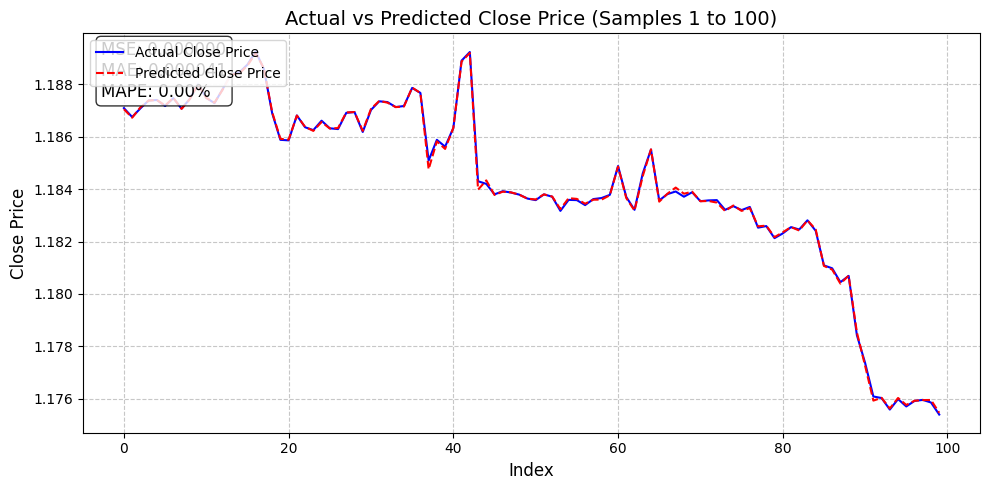

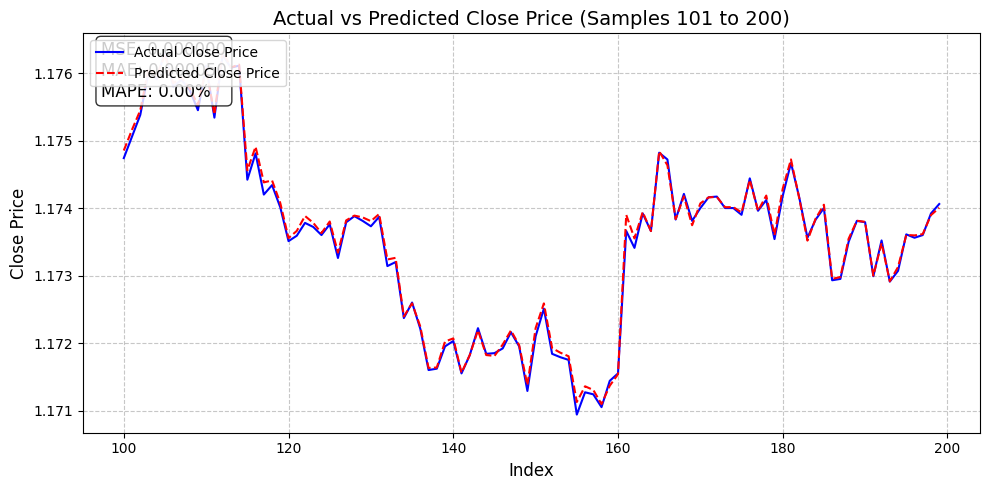

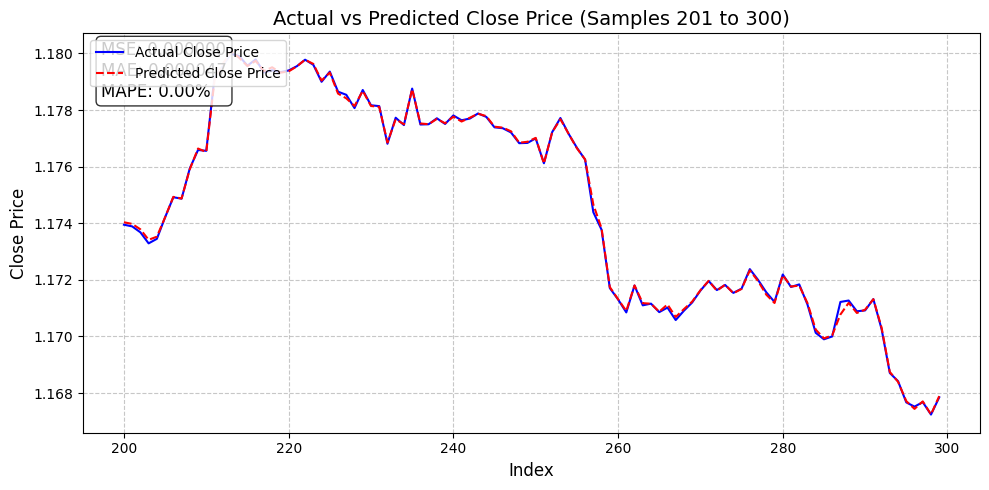

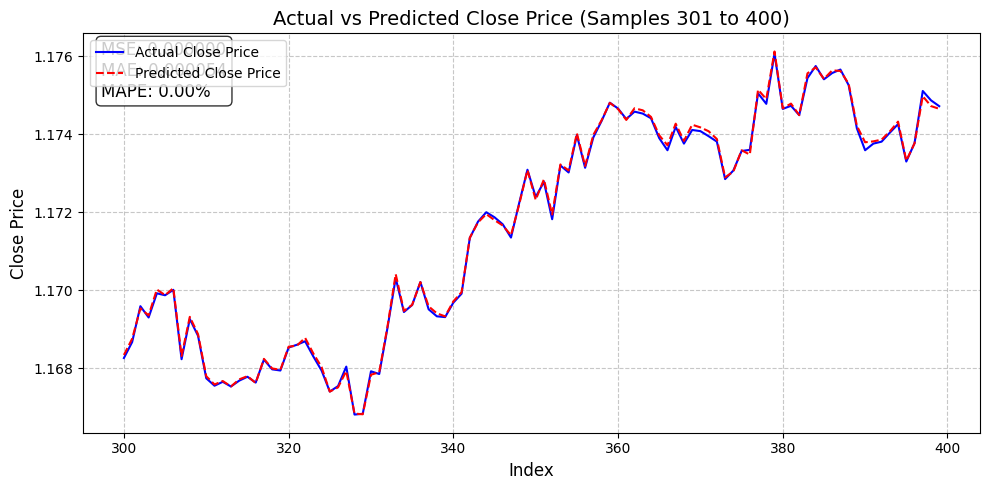

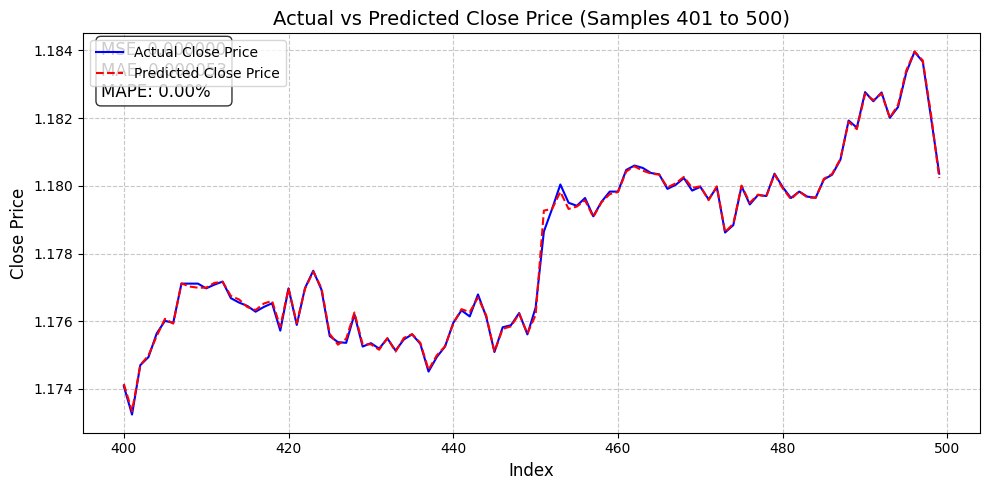

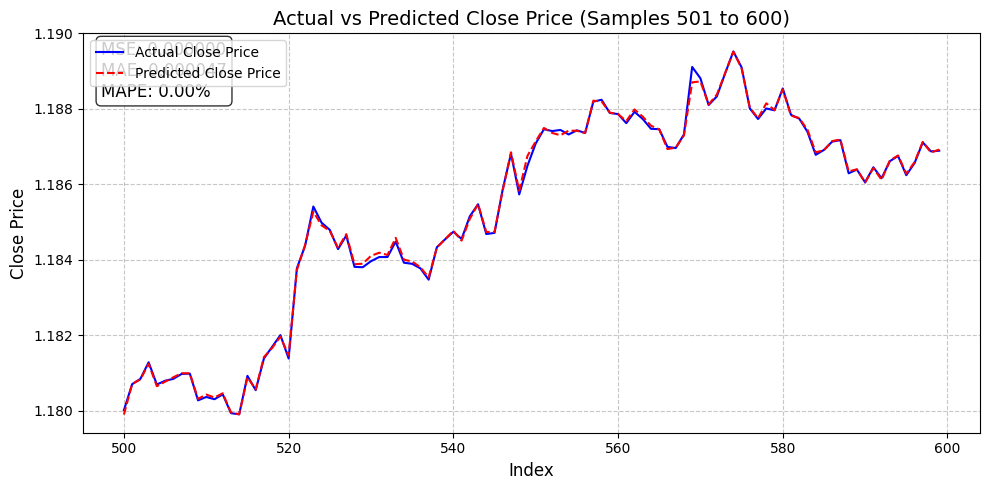

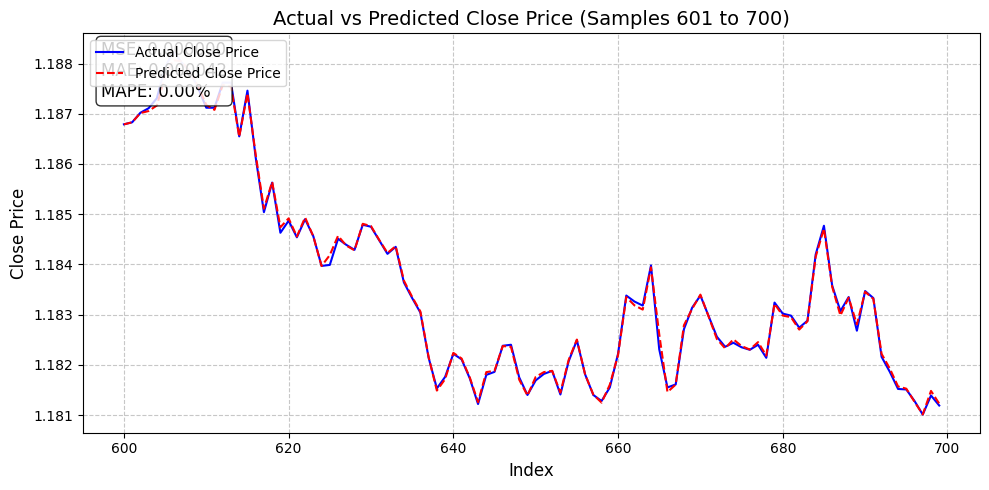

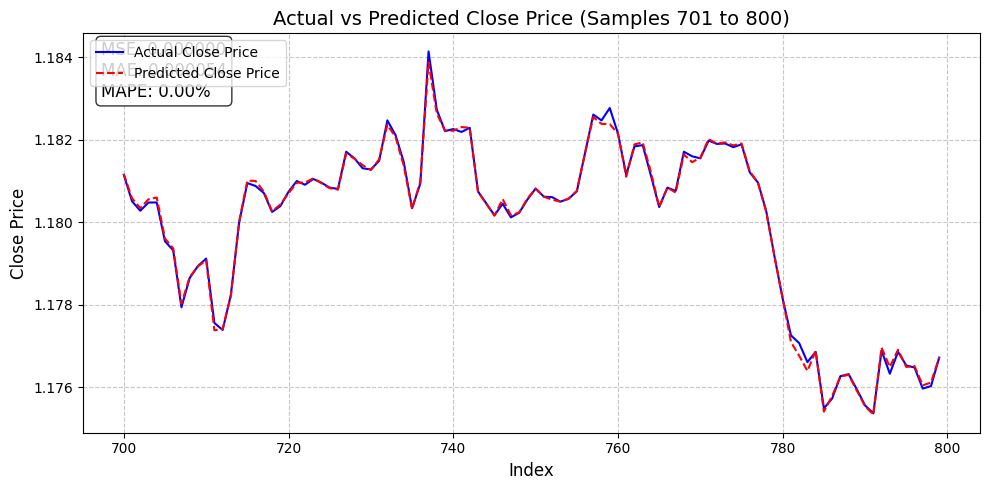

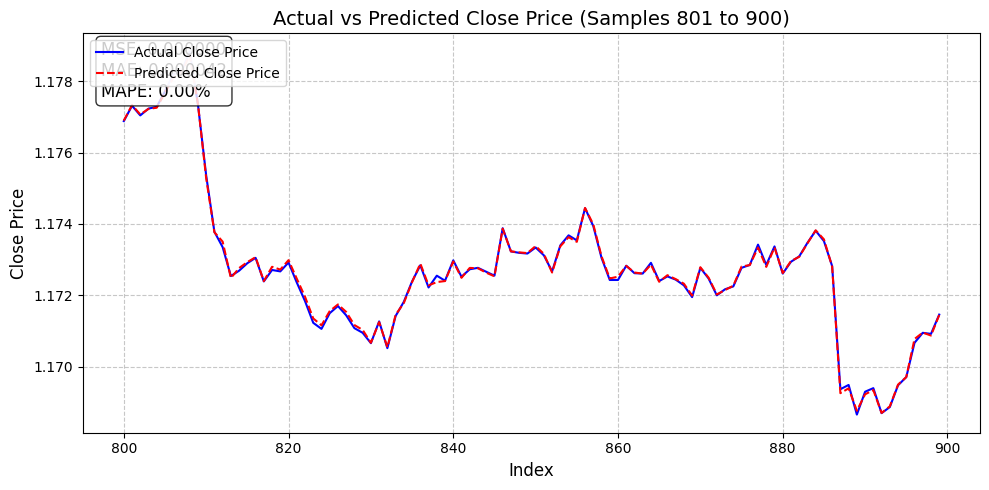

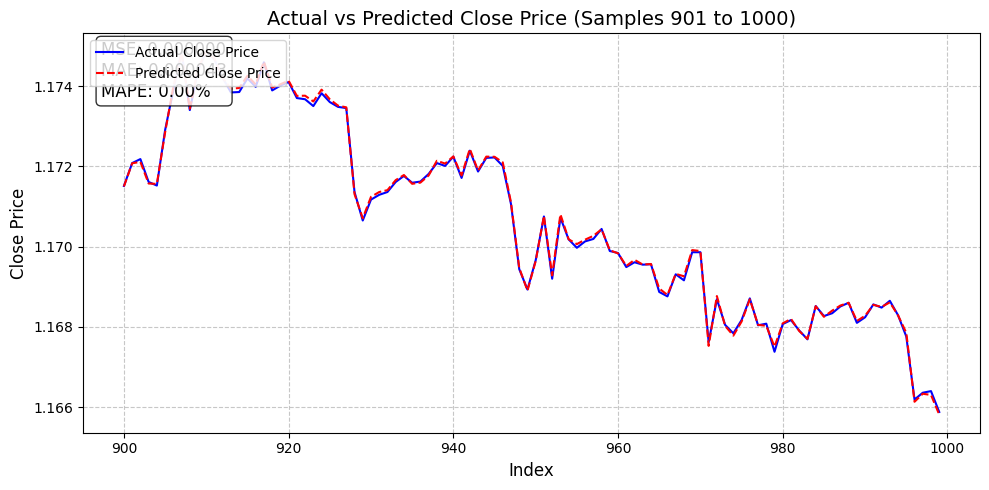

Overall Metrics:
MSE: 0.000000
MAE: 0.000195
MAPE: 0.02%


In [9]:
# پیش‌بینی
y_pred = model.predict(X_test)

# تبدیل پیش‌بینی تغییرات به قیمت
y_test_price = df['Close'].iloc[-len(y_test):].values
y_pred_price = y_test_price + y_pred

# معیارهای ارزیابی
mse = mean_squared_error(y_test_price, y_pred_price)
mae = mean_absolute_error(y_test_price, y_pred_price)
mape = np.mean(np.abs((y_test_price - y_pred_price) / y_test_price)) * 100

# رسم نمودارها
n_samples = 100
n_plots = min(10, len(y_test) // n_samples)

for i in range(n_plots):
    start_idx = i * n_samples
    end_idx = start_idx + n_samples
    y_test_chunk = y_test_price[start_idx:end_idx]
    y_pred_chunk = y_pred_price[start_idx:end_idx]

    mse_chunk = mean_squared_error(y_test_chunk, y_pred_chunk)
    mae_chunk = mean_absolute_error(y_test_chunk, y_pred_chunk)
    mape_chunk = np.mean(np.abs((y_test_chunk - y_pred_chunk) / y_test_chunk)) * 100

    plt.figure(figsize=(10, 5))
    plt.plot(range(start_idx, end_idx), y_test_chunk, label='Actual Close Price', color='blue', linewidth=1.5)
    plt.plot(range(start_idx, end_idx), y_pred_chunk, label='Predicted Close Price', color='red', linestyle='--', linewidth=1.5)

    plt.title(f'Actual vs Predicted Close Price (Samples {start_idx+1} to {end_idx})', fontsize=14)
    plt.xlabel('Index', fontsize=12)
    plt.ylabel('Close Price', fontsize=12)
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)

    metrics_text = f'MSE: {mse_chunk:.6f}\nMAE: {mae_chunk:.6f}\nMAPE: {mape_chunk:.2f}%'
    plt.text(0.02, 0.98, metrics_text, transform=plt.gca().transAxes, fontsize=12,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

print(f"Overall Metrics:\nMSE: {mse:.6f}\nMAE: {mae:.6f}\nMAPE: {mape:.2f}%")

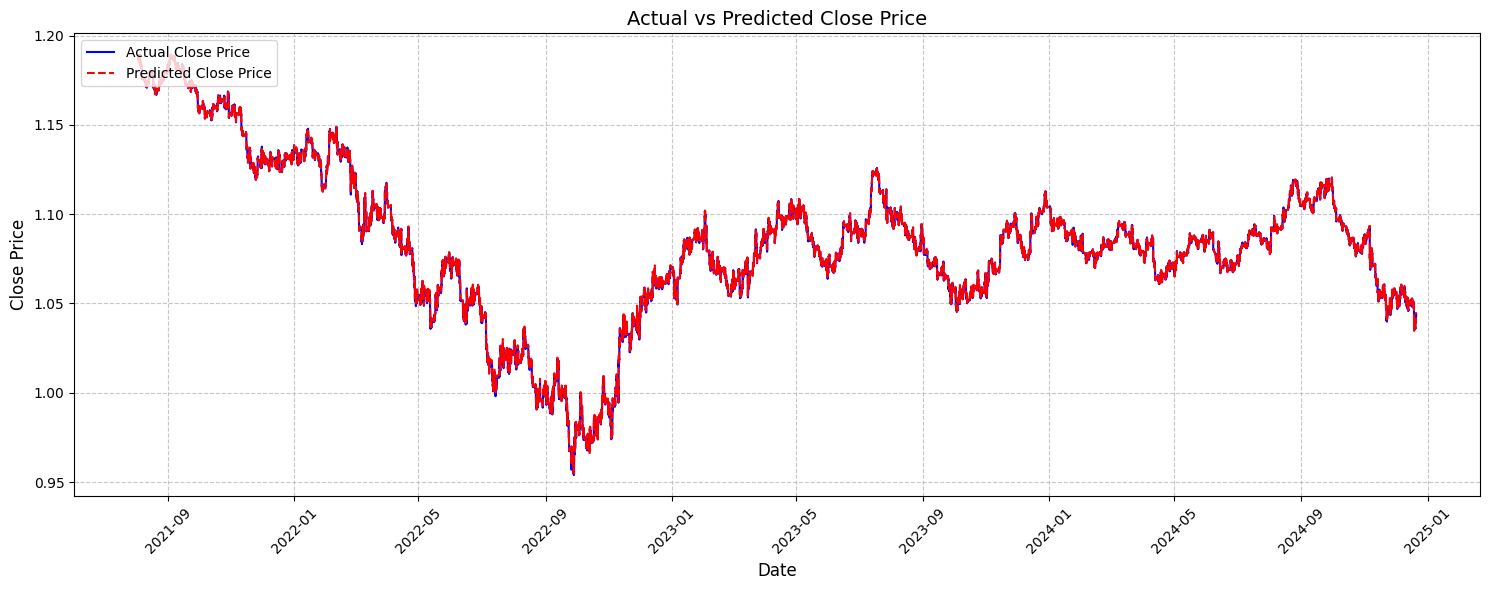

MSE: 0.000000
MAE: 0.000195
MAPE: 0.02%
R² Score: 0.9999


In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = model.predict(X_test)

# ۷. تبدیل پیش‌بینی تغییرات به قیمت
y_test_price = df['Close'].iloc[-len(y_test):].values
y_pred_price = y_test_price + y_pred

# ۸. رسم لاین پلات برای مقایسه y_test_price و y_pred_price
plt.figure(figsize=(15, 6))
plt.plot(df['Date'].iloc[-len(y_test):], y_test_price, label='Actual Close Price', color='blue', linewidth=1.5)
plt.plot(df['Date'].iloc[-len(y_test):], y_pred_price, label='Predicted Close Price', color='red', linestyle='--', linewidth=1.5)

# تنظیمات نمودار
plt.title('Actual vs Predicted Close Price', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ۹. محاسبه معیارهای ارزیابی (اختیاری)
mse = mean_squared_error(y_test_price, y_pred_price)
mae = mean_absolute_error(y_test_price, y_pred_price)
mape = np.mean(np.abs((y_test_price - y_pred_price) / y_test_price)) * 100
r2 = r2_score(y_test_price, y_pred_price)
print(f"MSE: {mse:.6f}\nMAE: {mae:.6f}\nMAPE: {mape:.2f}%\nR² Score: {r2:.4f}")

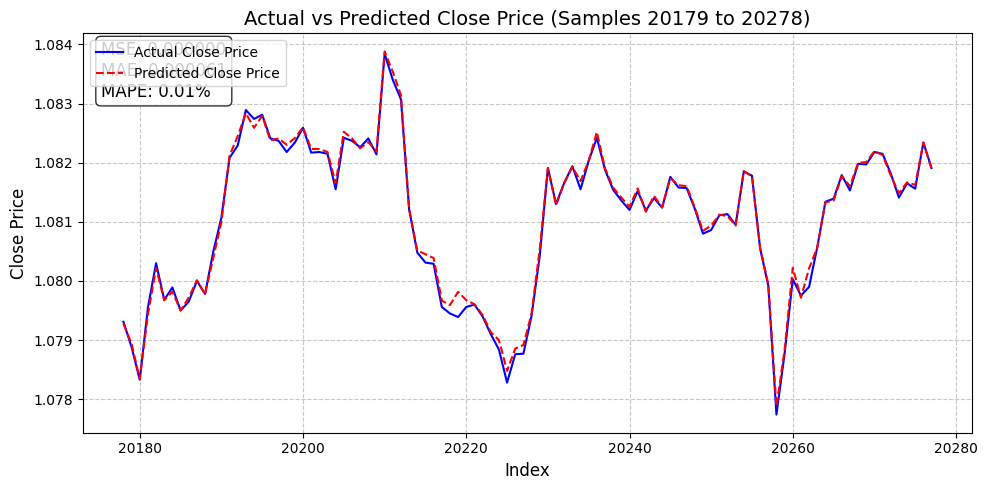

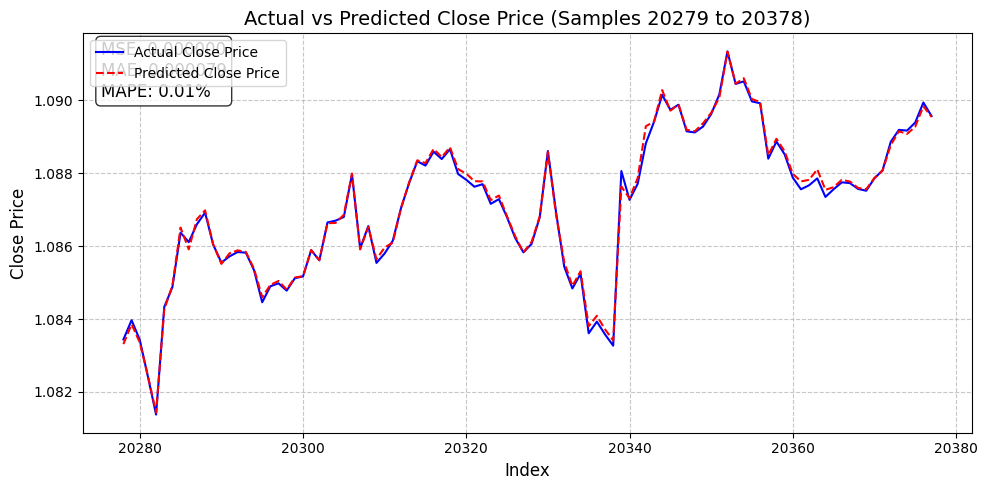

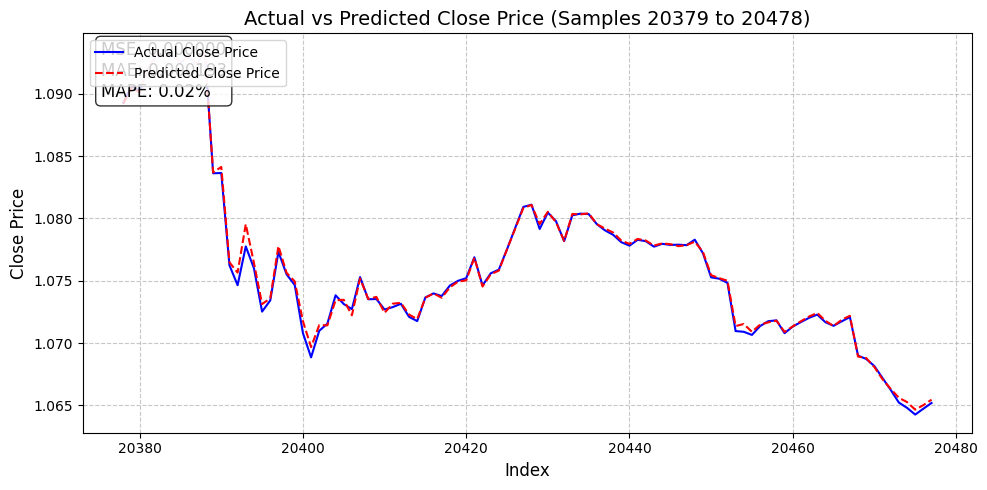

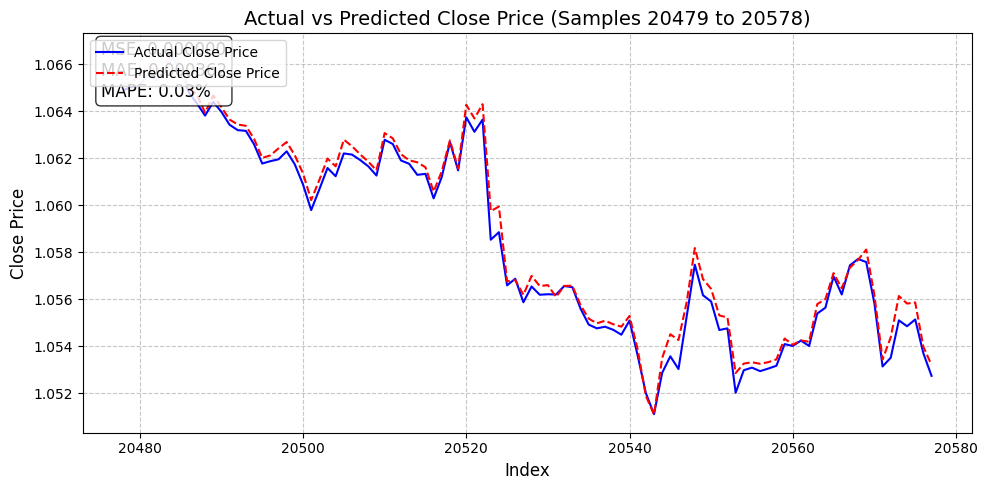

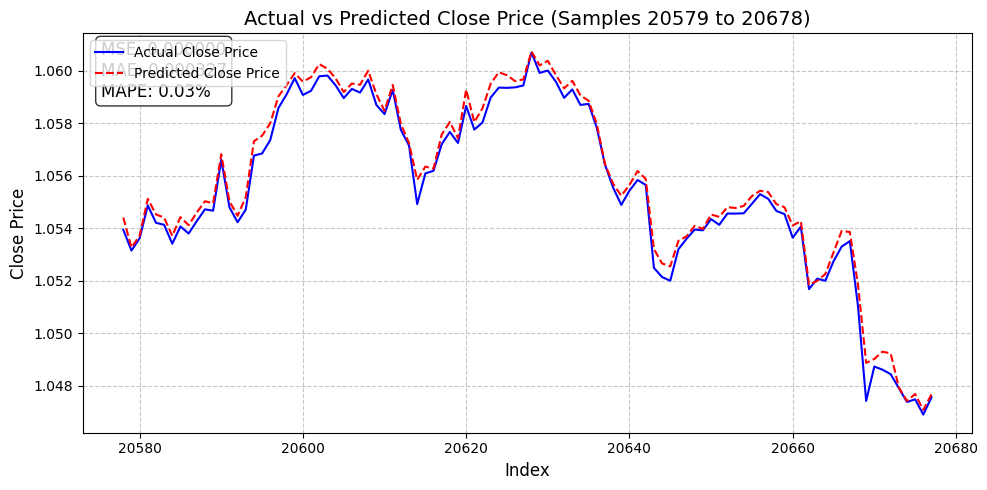

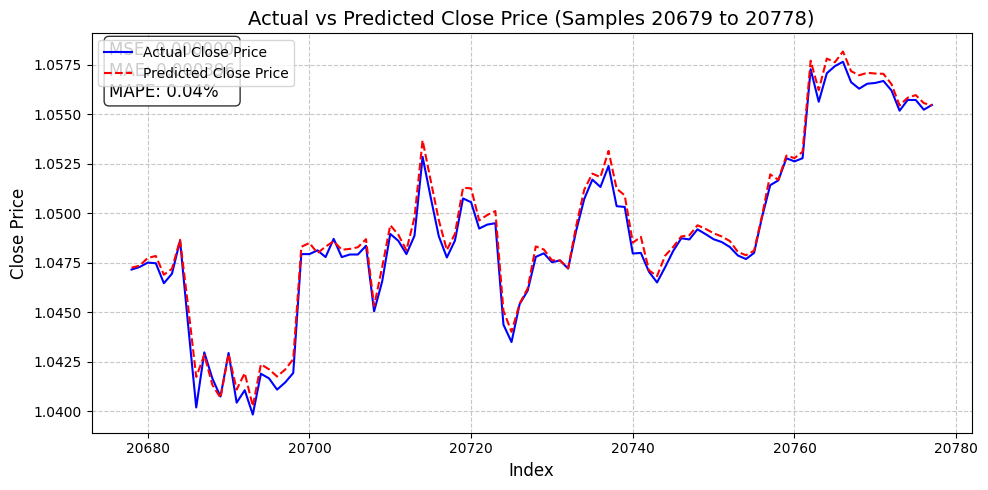

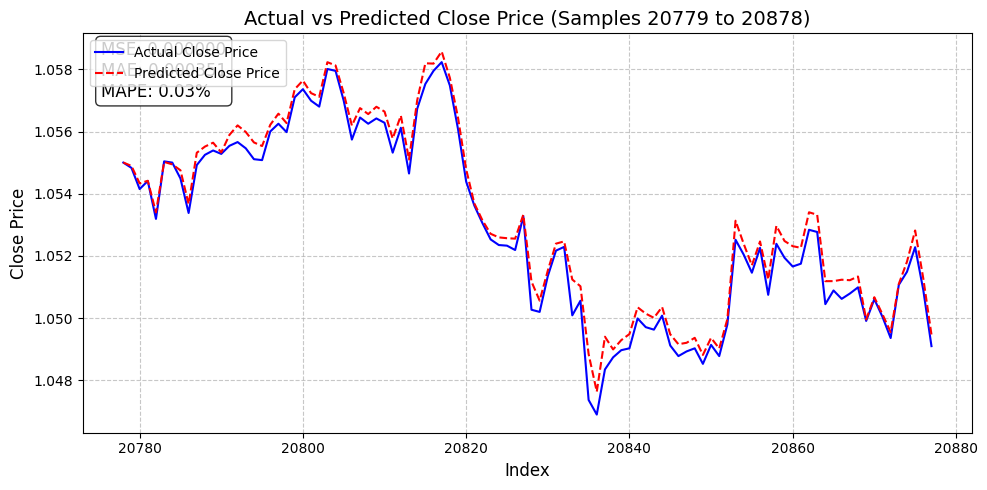

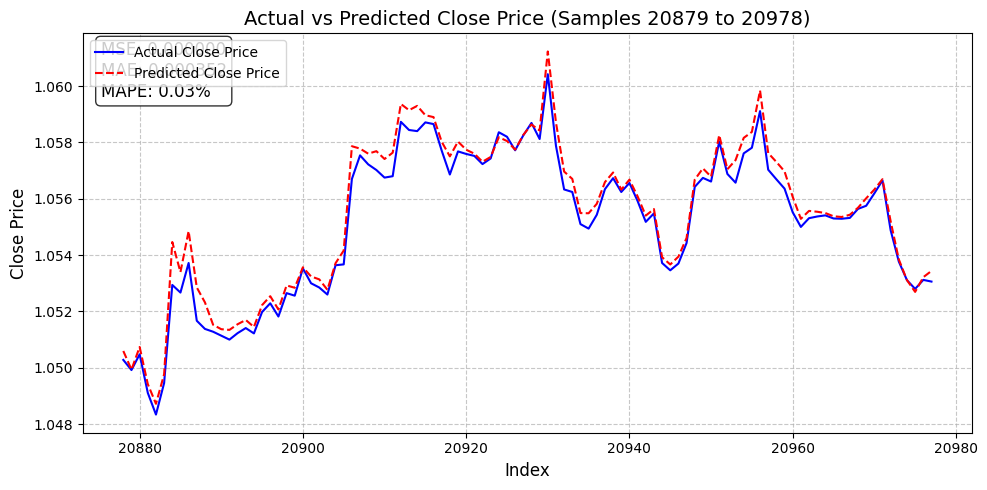

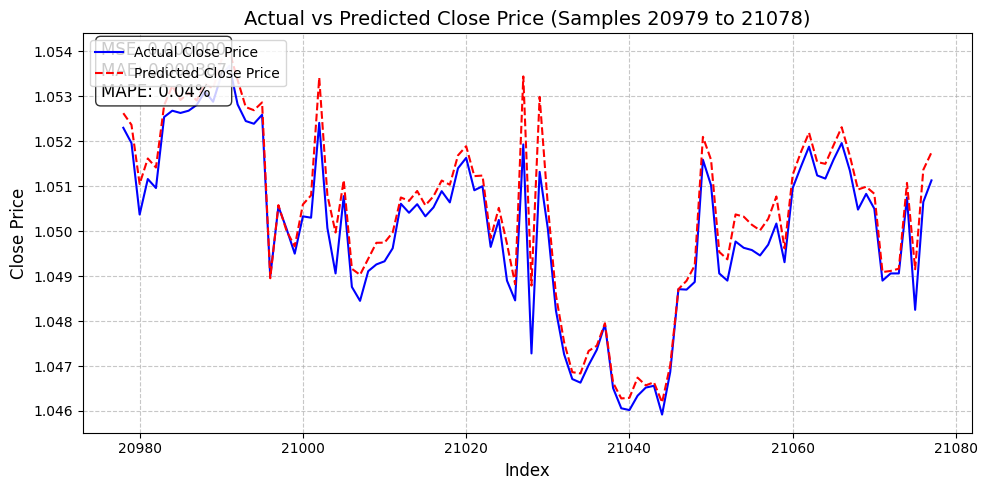

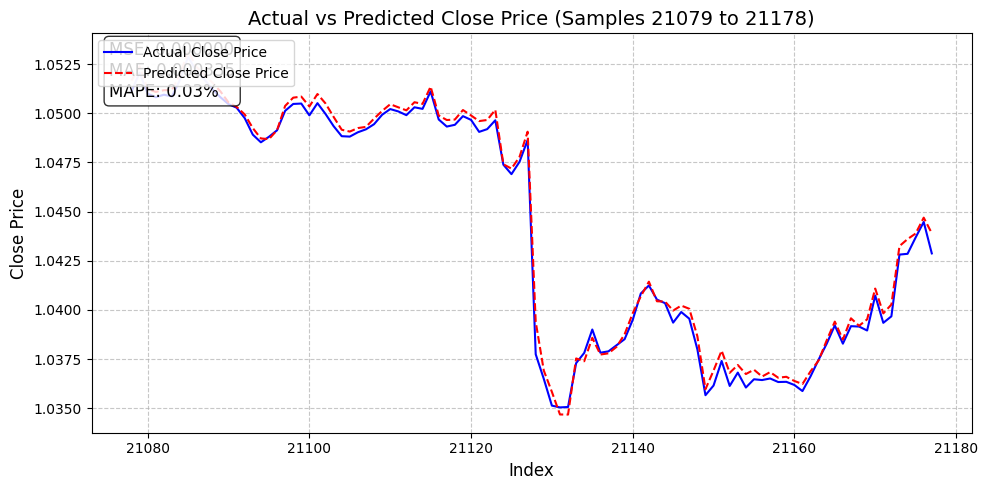

Overall Metrics:
MSE: 0.000000
MAE: 0.000195
MAPE: 0.02%


In [ ]:
# پیش‌بینی
y_pred = model.predict(X_test)

# تبدیل پیش‌بینی تغییرات به قیمت
y_test_price = df['Close'].iloc[-len(y_test):].values
y_pred_price = y_test_price + y_pred

# معیارهای ارزیابی
mse = mean_squared_error(y_test_price, y_pred_price)
mae = mean_absolute_error(y_test_price, y_pred_price)
mape = np.mean(np.abs((y_test_price - y_pred_price) / y_test_price)) * 100

# رسم نمودارها
n_samples = 100
n_plots = min(10, len(y_test) // n_samples)

# محاسبه ایندکس شروع برای ده دسته آخر
total_samples = len(y_test)
start_from = max(0, total_samples - n_samples * n_plots)  # شروع از n_plots دسته آخر

for i in range(n_plots):
    start_idx = start_from + i * n_samples
    end_idx = start_idx + n_samples
    y_test_chunk = y_test_price[start_idx:end_idx]
    y_pred_chunk = y_pred_price[start_idx:end_idx]

    mse_chunk = mean_squared_error(y_test_chunk, y_pred_chunk)
    mae_chunk = mean_absolute_error(y_test_chunk, y_pred_chunk)
    mape_chunk = np.mean(np.abs((y_test_chunk - y_pred_chunk) / y_test_chunk)) * 100

    plt.figure(figsize=(10, 5))
    plt.plot(range(start_idx, end_idx), y_test_chunk, label='Actual Close Price', color='blue', linewidth=1.5)
    plt.plot(range(start_idx, end_idx), y_pred_chunk, label='Predicted Close Price', color='red', linestyle='--', linewidth=1.5)

    plt.title(f'Actual vs Predicted Close Price (Samples {start_idx+1} to {end_idx})', fontsize=14)
    plt.xlabel('Index', fontsize=12)
    plt.ylabel('Close Price', fontsize=12)
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)

    metrics_text = f'MSE: {mse_chunk:.6f}\nMAE: {mae_chunk:.6f}\nMAPE: {mape_chunk:.2f}%'
    plt.text(0.02, 0.98, metrics_text, transform=plt.gca().transAxes, fontsize=12,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

print(f"Overall Metrics:\nMSE: {mse:.6f}\nMAE: {mae:.6f}\nMAPE: {mape:.2f}%")

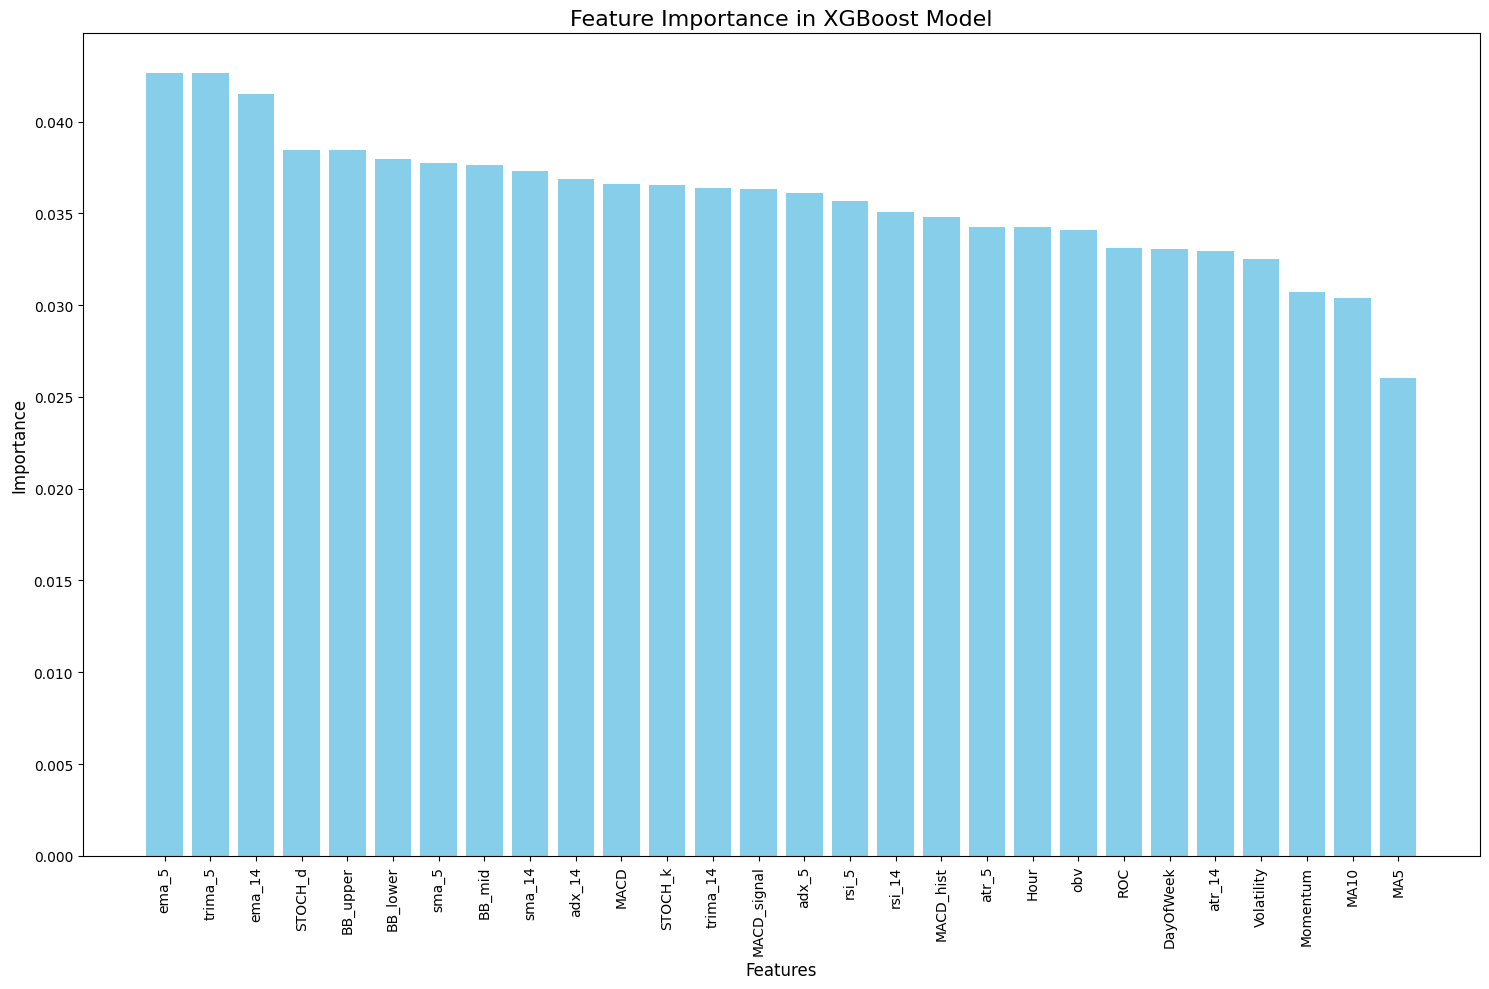

        Feature  Importance
7         ema_5    0.042670
11      trima_5    0.042646
8        ema_14    0.041497
27      STOCH_d    0.038451
23     BB_upper    0.038446
25     BB_lower    0.037949
9         sma_5    0.037753
24       BB_mid    0.037612
10       sma_14    0.037298
19       adx_14    0.036891
20         MACD    0.036618
26      STOCH_k    0.036532
12     trima_14    0.036380
21  MACD_signal    0.036304
18        adx_5    0.036105
13        rsi_5    0.035696
14       rsi_14    0.035078
22    MACD_hist    0.034786
15        atr_5    0.034270
5          Hour    0.034233
17          obv    0.034100
4           ROC    0.033095
6     DayOfWeek    0.033063
16       atr_14    0.032923
2    Volatility    0.032516
3      Momentum    0.030703
1          MA10    0.030370
0           MA5    0.026015


In [12]:
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(15, 10))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.title('Feature Importance in XGBoost Model', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

# چاپ اهمیت‌ها برای بررسی
print(feature_importance_df)


In [ ]:
y_pred_price

array([1.18704714, 1.18672401, 1.18711811, ..., 1.0438812 , 1.04468868,
       1.04389445])

In [ ]:
# مسیر ذخیره در Google Drive
save_path = '/content/drive/MyDrive/alphaniroo/XGBOOST/close_model.json'

# ذخیره مدل
model.save_model(save_path)
print(f"Model saved to {save_path}")

Model saved to /content/drive/MyDrive/alphaniroo/XGBOOST/close_model.json


In [14]:
import pickle
model_save_path = '/content/drive/MyDrive/alphaniroo/XGBOOST/close_model.pkl'
with open(model_save_path, 'wb') as f:
    pickle.dump(model, f)
print(f"Model saved to {model_save_path}")

# ۵. بارگذاری مدل با pickle
with open(model_save_path, 'rb') as f:
    loaded_model = pickle.load(f)
print(f"Model loaded from {model_save_path}")

Model saved to /content/drive/MyDrive/alphaniroo/XGBOOST/close_model.pkl
Model loaded from /content/drive/MyDrive/alphaniroo/XGBOOST/close_model.pkl


In [15]:
loaded_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [16]:
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)